# Project Goal
We are given a file with Twitter comments. Those comments are marked as positive/negative. We need to build a NLP model that will be able to predict the "toxicity" of comments with a minimum of 0.75 F1 Score.

# Project Plan
1. Project Goal
2. Project Plan
3. Libraries / Data Load
4. Exploratory Analysis
5. Data Preprocessing 
6. Base Model
7. Other Models
8. Results

# Libraries / Data Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import os
import random

from langdetect import detect
from collections import Counter

import nltk
import spacy
import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

In [2]:
random.seed(42)

In [3]:
local_path = './datasets/toxic_comments.csv'
web_path = '/datasets/toxic_comments.csv'

if os.path.exists(local_path):
  df = pd.read_csv(local_path, index_col=0)
elif os.path.exists(web_path):
  df = pd.read_csv(web_path, index_col=0)

In [4]:
df.sample(5)

,text,toxic
123153,"""\n\n RE: \nWhat I was trying to do is show hi...",0
33235,"""\n\nDates\nYou wrote """"Rationalise non-US dat...",0
106324,"that's as far as my civility stretches, pal! I...",0
157554,"Its been months now\n\nLook Ben, I started by ...",0
58323,"""\n\n Solution \n\nThis is save Venice, and I ...",0


# Exploratory Analysis

- Good Link
- Exploritory Data Analysis for NLP
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


<Axes: >

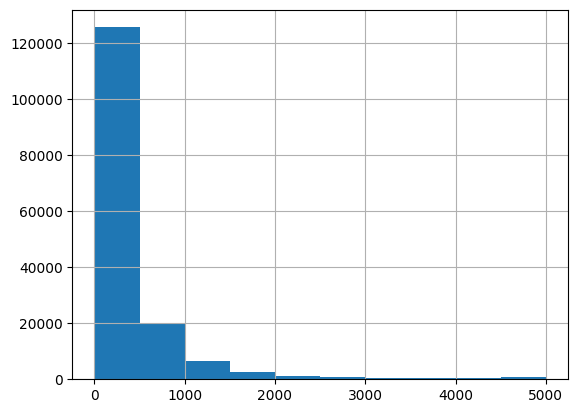

In [6]:
df.text.str.len().hist()

Most Text contain less than 200 characters

<Axes: >

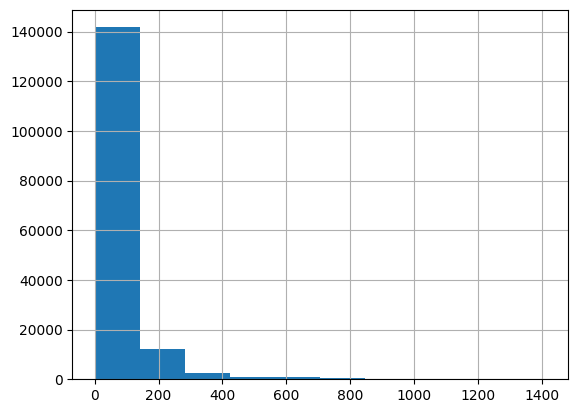

In [7]:
df.text.str.split().map(lambda x: len(x)).hist()

A lot of texts contain less than 400 words

<Axes: >

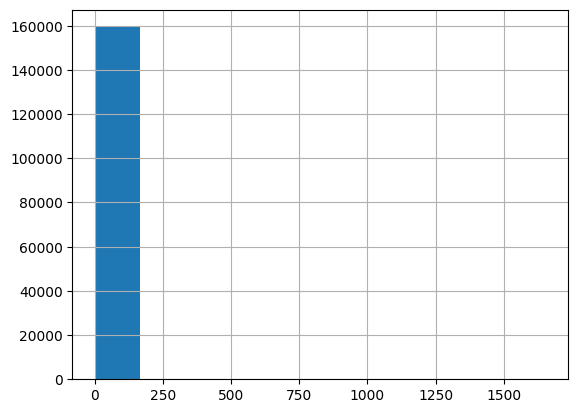

In [8]:
df.text.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

По этому графику видно что длина слов иммеет выбросы в данных.

In [9]:
def safe_detect(text):
    try:
        return detect(text)
    except:
        return '--'

languages = df.text.sample(1000).apply(lambda x: safe_detect(x))
unique_languages = languages.unique()

print("Languages found in dataframe:")
print(unique_languages)

Languages found in dataframe:
['en' 'so' 'sv' 'fr' 'tr' 'de' 'tl' 'nl' 'sk' 'et' 'fi' 'da' 'af' 'es'
 'hr']


A lot of different languages

In [ ]:
stop = set(nltk.corpus.stopwords.words('english'))

counter_toxic = Counter(
    np.concatenate(
        df[df.toxic == 1].text\
            .sample(1000).str.lower()\
                .str.split().values))
most = counter_toxic.most_common()

x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x)

# Data Preprocessing

- Useful Post https://www.datacamp.com/tutorial/stemming-lemmatization-python

- Simple language preprocessing.
  - Remove all characters.
  - Tokenize the text.
  - Lemmatize the text.
  - Build bag of words.

In [11]:
pattern_numbers_characters = r'[\d\W]'
df['text'] = df['text'].str.lower().str.replace(pattern_numbers_characters, ' ', regex=True)

In [12]:
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m s...,0
2,hey man i m really not trying to edit war it...,0
3,more i can t make any real suggestions on im...,0
4,you sir are my hero any chance you remember...,0


In [13]:
nlp = spacy.load('en_core_web_sm')
def lemma_clear(text): 
      
    lemm = nlp(text) 
    lemm = " ".join([token.lemma_ for token in lemm])  
    return " ".join(lemm.split())

In [14]:
%%time

df['text'] = df['text'].apply(lambda x: lemma_clear(x))

CPU times: user 36min 2s, sys: 29 s, total: 36min 31s
Wall time: 36min 34s


In [15]:
train, test = train_test_split(df, test_size=0.4, random_state=0)

In [16]:
valid, test = train_test_split(test, test_size=0.5, random_state=0)

# Hyperparameter tunning

In [17]:
%%time

params={'model__C':[.01,.05,.1,.5,1,5,10],
           'model__penalty':['l2']}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression(max_iter=1000))])
grid_lr = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')
grid_lr.fit(train['text'], train['toxic'])
grid_lr.score(valid['text'], valid['toxic'])

CPU times: user 28.5 s, sys: 3.43 s, total: 31.9 s
Wall time: 7min 59s


0.7816052359627971

In [18]:
%%time

params={'model__n_estimators': [50, 100], 'model__max_depth': [50, 100]}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40, ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier())])
grid_rfc = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')
grid_rfc.fit(train['text'], train['toxic'])
grid_rfc.score(valid['text'], valid['toxic'])

CPU times: user 1min 12s, sys: 2.19 s, total: 1min 14s
Wall time: 5min 55s


0.5641249726895347

# Results

In [19]:
z_test = grid_lr.predict(test['text'])
f1_score(test['toxic'], z_test)

0.7650551314673453